# CS 6140 Machine Learning: Assignment - 4 (Total Points: 100)
## Prof. Ahmad Uzair 

## Darrel Schreiner

## Q1. Random Forest (50 points) 

**Random forests**, also known as **Random Decision Forests**, are an ensemble learning method for classification, regression, and other problems that works by training a large number of **decision trees**. For classification tasks, the random forest's output is the class chosen by the majority of trees. The mean or average prediction of the individual trees is returned for regression tasks. In this assignment we will be using Random Forest Classifier to predict the possibility of breast cancer being benign or not.

Note that the code for building a decision tree will be similar to your first assignment. Feel free to reuse the code from your first assignment but be ware of the differences.

In [1]:
# Do not change anything in this cell.
import numpy as np
import pandas as pd
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
from math import sqrt

We are using the breast cancer dataset provided in scikit-learn. Here is a look at your dataset.

In [5]:
# Do not change anything in this cell.
data = pd.read_csv("df_psych_factors_data.csv")
data.drop("Unnamed: 0", axis=1, inplace=True)
data.head()

Number of Image Familiarity  Security Values  Online Security Importance  \
0                            3              2.0                         6.0   
1                            5              2.0                         3.0   
2                            3              2.0                         2.0   
3                            4              2.0                         6.0   
4                            4              2.0                         6.0   

   Quick Log In Importance  Usability Importance  Convenience Importance  \
0                      7.0                   7.0                     5.0   
1                      8.0                   6.0                     3.0   
2                      6.0                   5.0                     4.0   
3                      8.0                   7.0                     6.0   
4                      8.0                   7.0                     6.0   

   Log In Satisfaction  MFA Use  
0                  5.0      2.0  
1                  5.0      3.0  
2                  4.0      3.0  
3                  7.0      2.0  
4                  7.0      2.0

In [12]:
# set X and y
X = data.iloc[:,:-1]
print(X)
y = data.iloc[:,-1]
print(y)

     Number of Image Familiarity  Security Values  Online Security Importance  \
0                              3              2.0                         6.0   
1                              5              2.0                         3.0   
2                              3              2.0                         2.0   
3                              4              2.0                         6.0   
4                              4              2.0                         6.0   
..                           ...              ...                         ...   
181                            2              2.0                         6.0   
182                            2              2.0                         4.0   
183                            5              2.0                         6.0   
184                            5              2.0                         6.0   
185                            5              2.0                         3.0   

     Quick Log In Importanc

In [13]:
# Do not change anything in this cell.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Number of Image Familiarity  186 non-null    int64  
 1   Security Values              186 non-null    float64
 2   Online Security Importance   186 non-null    float64
 3   Quick Log In Importance      186 non-null    float64
 4   Usability Importance         186 non-null    float64
 5   Convenience Importance       186 non-null    float64
 6   Log In Satisfaction          186 non-null    float64
 7   MFA Use                      186 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 11.8 KB


In [14]:
data.describe()

Number of Image Familiarity  Security Values  \
count                   186.000000       186.000000   
mean                      3.596774         1.892473   
std                       1.312637         0.427750   
min                       0.000000         0.000000   
25%                       3.000000         2.000000   
50%                       4.000000         2.000000   
75%                       5.000000         2.000000   
max                       5.000000         2.000000   

       Online Security Importance  Quick Log In Importance  \
count                  186.000000               186.000000   
mean                     5.365591                 6.806452   
std                      1.146416                 1.550993   
min                      0.000000                 0.000000   
25%                      5.000000                 6.000000   
50%                      6.000000                 7.000000   
75%                      6.000000                 8.000000   
max                      6.000000                 8.000000   

       Usability Importance  Convenience Importance  Log In Satisfaction  \
count            186.000000              186.000000            186.00000   
mean               5.833333                4.892473              5.27957   
std                1.390767                1.444186              1.52362   
min                0.000000                0.000000              0.00000   
25%                5.000000                4.000000              4.00000   
50%                6.000000                5.000000              5.00000   
75%                7.000000                6.000000              7.00000   
max                7.000000                6.000000              7.00000   

          MFA Use  
count  186.000000  
mean     1.806452  
std      1.155556  
min      0.000000  
25%      0.250000  
50%      2.000000  
75%      3.000000  
max      3.000000

In [15]:
# Write a function to calculate the entropy. We will be using this to calculate
## the information gain for decision tree.
def entropy(y):
    # find the unique class labels
    class_labels = np.unique(y)
    entropy = 0
    # for each class calculate the probability of the class 
    for cls in class_labels:
        p_cls = len(y[y== cls]) / len(y)
        # use entropy equation (sum of the probabilities * log of probabilities)
        entropy += -p_cls * np.log2(p_cls)
    return entropy

In [16]:
# Do not change anything in this cell.
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [17]:
# Write code in this cell to build your Decision Trees used for Random Forest Classifier
#This will be similar to assignment 1, but keep in mind that we will randomly pick 
#a subset of features for splitting, at then choose the best variable/split-point among those
class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, num_features=None):
        # Initialize the min_split,max_depth, root and num_features are set to None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_features = num_features
        self.root = None

    # Function to train the decision tree
    def fit(self, X, y):
        """
        Function to train the tree.
        X: Features
        Y: Target
        """
        self.num_features = X.shape[1] if not self.num_features else min(self.num_features, X.shape[1])
        self.root = self.build_tree(X, y)

    # Write a function to predict the results for a given dataset, using the tree you built 
    #and the tree traversal function
    def predict(self, X):
        """
        Prediction function to calculate the all the predictions of the matrix of features 
        provided using make_predictions function
        X: Matrix of features
        Returns predictions
        """
        # make predictions by calling tree traversal method and store the predictions 
        predictions = [self.tree_traversal(x, self.root) for x in X]
        # return the predictions
        return np.array(predictions)

    # build the decision tree
    def build_tree(self, X, y, depth=0):
        """
        This will be a recursive function to build the decision tree.
        X: The data that you will be using for your assignment
        y: Target
        depth: Current depth of the tree
        Returns the leaf node
        """
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria should be when depth equals or exceeds max depth
        # or there is only one label at the node
        # or when n_samples gets smaller than min_samples_split
        if (depth >= self.max_depth or n_labels==1 or n_samples < self.min_samples_split):
            leaf_value = self.max_frequency_label(y)
            return Node(value=leaf_value)
        
        # select the features **randomly**. Hint: you can use functions like np.random.choice
        feature_idxs = np.random.choice(n_features, self.num_features, replace=False)

        # find the best split according to information gain
        # use the optimal criterion method to get the index of the best feature and value of optimal split threshold
        best_feat, best_thresh = self.optimal_criterion(X,y, feature_idxs)
      
        # Take the result from the split and recuisively grow the tree
        # building left side of tree using best_feat and thresh above in split method on the left side of data

        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self.build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self.build_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def optimal_criterion(self, X, y, feature_idxs):
        """
        Find the optimal criterion for the split of the tree, using the selected features.
        X: dataset
        y: target
        feature_idxs: randomly selected feature idxs
        Return split index and threshold
        """
        # initialize the best gain
        best_gain = -1
        split_idx, split_thresh = None, None
        # use the feature indexes to find the information gain
        # loop over features
        for feature_idx in feature_idxs:
            # define the X_column for informatin gain (all of rows of specific feature indx)
            X_column = X[:, feature_idx]
            # get unique features
            possible_thresholds = np.unique(X_column)
            for threshold in possible_thresholds:
                # get current info gain
                curr_info_gain = self._information_gain(y, X_column, threshold)
                if curr_info_gain > best_gain:
                    #update best gain, split_idx and split_thresh
                    best_gain = curr_info_gain
                    split_idx = feature_idx
                    split_thresh = threshold
        
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        """
        Function to return the information gain
        y: target
        X: data
        split_thresh: threshold for split
        Return Information gain
        """
        # parent loss
        parent_entropy = entropy(y)
  
        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        
        # calculate the weights
        weight_l = len(left_idxs) / len(y)
        weight_r = len(right_idxs) / len(y)
        # condition to handle no left or right indexes
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            information_gain = 0 
        # information gain is the parent - sum of child entropy * respective weights
        else:
            information_gain = parent_entropy - (weight_l * entropy(y[left_idxs]) + weight_r * entropy(y[right_idxs]))
        return information_gain

    def _split(self, X_column, split_thresh):
        """
        (Already implemented)
        The split function 
        X_column: data
        split_thresh: threshold value
        Return left_idxs, right_idxs
        """
        # Function to split the tree
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
  
    def tree_traversal(self, x, node):
        """
        Tree traversal method which returns (one of) the leaf node value
        x: data
        node: node of the tree
        """
        if node.is_leaf_node():
            return node.value
  
        if x[node.feature] <= node.threshold:
            return self.tree_traversal(x, node.left)
        return self.tree_traversal(x, node.right)

    def max_frequency_label(self, y):
        """
        Determine the target label with maximum frequency. Hint: You can use collections.Counter()
        y: target
        """
        # use counter to find most common label (only 1 value)
        most_common = Counter(y).most_common(1)[0][0]
        return most_common


In [18]:
def bootstrap_sample(X, y):
    # Function for bootstrap sampling to give tree random subset of data. Hint: use np.random.choice for idxs
    num_samples =X.shape[0]
    idxs = np.random.choice(num_samples, num_samples, replace=True)
    X_sample, y_samples = X[idxs], y[idxs]
    return X_sample, y_samples

def most_common_label(y):
    """
    Determine the target label with maximum frequency. Again, you can use collections.Counter()
    y: target
    """
    most_common = Counter(y).most_common(1)[0][0]
    return most_common

In [19]:
# random forest has more chances to get the correct prediction of dataset
# reduce the chance of overfitting vs a single tree 
class RandomForest:
    
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, num_features=None):
        # Initialize the variabes
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_features = num_features
        self.trees = []

    def fit(self, X, y):
        """
        Create n_tree decision trees using the training data
        X: data (training data)
        y: target labels
        """
        # empty list to store trees
        self.trees = []
        
        # train trees
        for _ in range(self.n_trees):
            # create our tree
            tree = DecisionTree(
                min_samples_split=self.min_samples_split, max_depth=self.max_depth,
                num_features=self.num_features)
            
            # use the bootstrap samples to create training samples
            X_samp, y_samp = bootstrap_sample(X, y)
            # call the fit function using the bootstrap samples on tree
            tree.fit(X_samp, y_samp)
            # add to tree list
            self.trees.append(tree)

    def predict(self, X):
        """
        Write a predict function to make predictions
        X: data (test data)
        Return predictions
        """
        # bootstrap aggregation trees of tree predictions for each tree
        bagged_trees = np.array([tree.predict(X) for tree in self.trees])
        # swap axes to compare tree predictions against eachother
        tree_predictions = np.swapaxes(bagged_trees, 0, 1)
        # store most common label of tree predictions
        predict_vals = [most_common_label(tree_prediction) for tree_prediction in tree_predictions]
        # store in array
        y_pred = np.array(predict_vals)
        return y_pred

In [20]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [21]:
# Do not change anything in this cell
import time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
for n_trees in [1,3,5,10,20]:
    clf = RandomForest(n_trees=n_trees, max_depth=10)
    start = time.time()
    clf.fit(X_train, y_train)
    train_finish = time.time()
    y_pred = clf.predict(X_test)
    test_finish = time.time()
    acc = accuracy(y_test, y_pred)
    print (f"Num of trees : {n_trees} Accuracy: {acc:.2f} Training took {train_finish-start:.2f}s Testing took {test_finish - train_finish:.2f}s")

KeyError: "None of [Int64Index([127,  25, 139,  81,  37, 147,  21,  35,  95,  23,\n            ...\n             55, 114,  72, 115,  39,  73,  54, 134,   3,  90],\n           dtype='int64', length=148)] are in the [columns]"

## Q2. Clustering (35 points) 

### K-Means Clustering
For this question, you will use the **K-Means** clustering algorithm to cluster the yeast dataset. You will experiment with different k values, and report the Sum of Squared Errors (see below) for each k.



### Sum of Squared Errors (SSE)
Assume that we have a clustering for our data $X$ having $K$ clusters. Each cluster is characterized by it’s centroid $C_k$ . The sum of squared error criterion for one cluster can be defined as:
$$SSE(X,C =k)= \sum_{x_i \in cluster_k}||x_i −C_k||2 $$ 
then, the overall SSE for the K clusters can be calculated as:

$$ SSE(X)= \sum_{k=1}^K SSE(X,C=k)$$
SSE provides a notion of how compact the clusters are and we are going to favor clusters that are more compact, hence we will look for clusterings that minimize SSE. This is an internal clustering quality criterion as we can estimate it using just the cluster labels.

In [12]:
import numpy
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt

In [13]:
# =============================================================================#
# Load a CSV file
def load_csv(filename):
    data = pd.read_csv(filename, header=None)
    dataset = data.values
    return dataset

In [14]:
# =============================================================================#
'''
Initialize the k centroids.
Selecting k random points as intial points from dataset
'''
def initialize_centroids(k, dataset):
    # create an empty list to hold the centroids
    centroids = []
    # add the random points to the list to give us our centroids
    for i in range(k):
        centroids.append(dataset[i])
    return centroids


In [15]:
# =============================================================================#
def calculate_znk(data, centroids, k, n):
    '''
    Assign each point to the closest centroid, using a Matrix Z to represent the assignments
    creating the matrix 
    '''
    # creating array of zeros size of datapoints
    znk = numpy.array([[0 for i in range(k)] for j in range(n)])
    
    i = 0
    # for each row in the data and each centroid calculate the euclidean distance from centroid
    for row in data:
        distances = []
        for centroid in centroids:
            distance = np.linalg.norm(row-centroid)
            distances.append(distance)
        # store index of the minimum distances 
        index = distances.index(min(distances))
        # assign 1.0 points within in cluster k
        znk[i][index] = 1.0
        i+=1
    
    return znk

In [16]:
# =============================================================================#
def calculate_centroids_and_SSE(k, znk, data, cen):
    '''
    Calculate the k centroids and the SSE
    k: int, # of centroids
    znk: centroid matrix
    '''
    # calculate the centroid values and sum of squared errors
    centroids = []
    SSE = []
    outer_index = 0
    
    for i in range(k):
        new_list = []
        indx = 0
        sum_of_squared_errors = 0.0
        # going through the matrix
        for row in znk:
            # if the data is part of the cluster
            if row[i] == 1.0:
                new_list.append(data[i])
                # calculate the sum of sqaured errors
                sum_of_squared_errors += abs(np.linalg.norm(cen[outer_index] - data[indx])) ** 2
            indx += 1
        # convert list to array
        new_list = np.array(new_list)
        
        centroids.append(new_list.mean(axis=0))
        
        SSE.append(sum_of_squared_errors)
        total_SSE = SSE
        outer_index += 1
        
    return centroids, total_SSE

In [17]:
# =============================================================================#
def k_means_algorithm(dataset, k, max_iterations, thresh = 0.01):
    '''
    Do k-means by iteratively calculating the centroids and assigning the data points to one of the centroids
    until either we reach the max_iter or SSE does not decrease by more than the threshold.
    Do not use the last column, as they are the labels.
    '''
    # using the above methods to iteratively redefine clusters
    centroids = initialize_centroids(k, dataset)
    n = len(dataset)
    data = []
    cen = []
    
    # adding centroids
    for row in dataset:
        data.append(row[:-1])
    data = np.array(data)
    for row in centroids:
        cen.append(row[:-1])
    cen = np.array(cen)
    
    centroids = cen
    
    prev_SSE = math.inf
    #iteratively calculating centroids and assigning datapoints
    for i in range(max_iterations):
        # assign points to the closest center
        znk = calculate_znk(data, centroids, k, n)
        # recalculate centroids
        centroids, total_SSE = calculate_centroids_and_SSE(k, znk, data, centroids)
        total_SSE = sum(total_SSE)
        
        thresh = 0.01
        if prev_SSE - total_SSE <= thresh:
            #stop when SSE does not decrease by more than the threshold
            return prev_SSE, znk, centroids

        prev_SSE = total_SSE



SSE for k= 2 is 152.25630000000007
SSE for k= 4 is 126.05160000000004
SSE for k= 6 is 98.23590000000002
SSE for k= 8 is 80.52799999999999
SSE for k= 10 is 72.9524
SSE for k= 12 is 66.97550000000001
SSE for k= 14 is 65.00940000000001
SSE for k= 16 is 62.455099999999995
SSE for k= 18 is 59.487199999999994
--------------------------------------------------


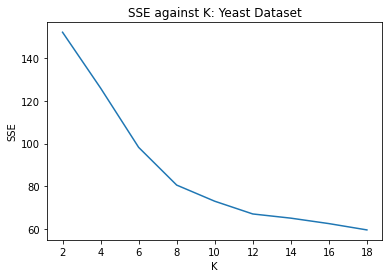

In [18]:
# =============================================================================#
# MAIN FUNCTION, DO NOT MODIFY
dataset_name = 'yeastData.csv'
# Careful, the dataset also consists of labels
dataset = load_csv(dataset_name)
max_iterations = 100
sum_sq_error = []


K = numpy.arange(2, 20, 2)
for k in K:
    SSE, znk, centroids = k_means_algorithm(dataset, k, max_iterations)
    sum_sq_error.append(SSE)
    print("SSE for k= ", end='')
    print(k, end='')
    print(' is ', end='')
    print(SSE)


print("-" * 50)
plt.plot(K, sum_sq_error)
plt.title("SSE against K: Yeast Dataset")
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()


## Q3. Theory (15 points) 

1.(4 points) Verify that if we minimize the sum-of-squares error between a set of training values {$t_n$} and a single predictive value $t$, then the optimal solution for $t$ is given by the mean of the {$t_n$}. 

2.(7 points) Consider the K-means algorithm. Show that as a consequence of there being a finite number of possible assignments for the set of discrete indicator variables $z_{nk}$, and that for each such assignment there is a unique optimum for the centroids, the K-means algorithm must converge after a finite number of iterations.

3.(4 points) In Q2 we initialize the centroids of the clusters by simply picking the first $k$ data points from the dataset. There are many alternative ways. Provide two other ways of initializing the centroids. 



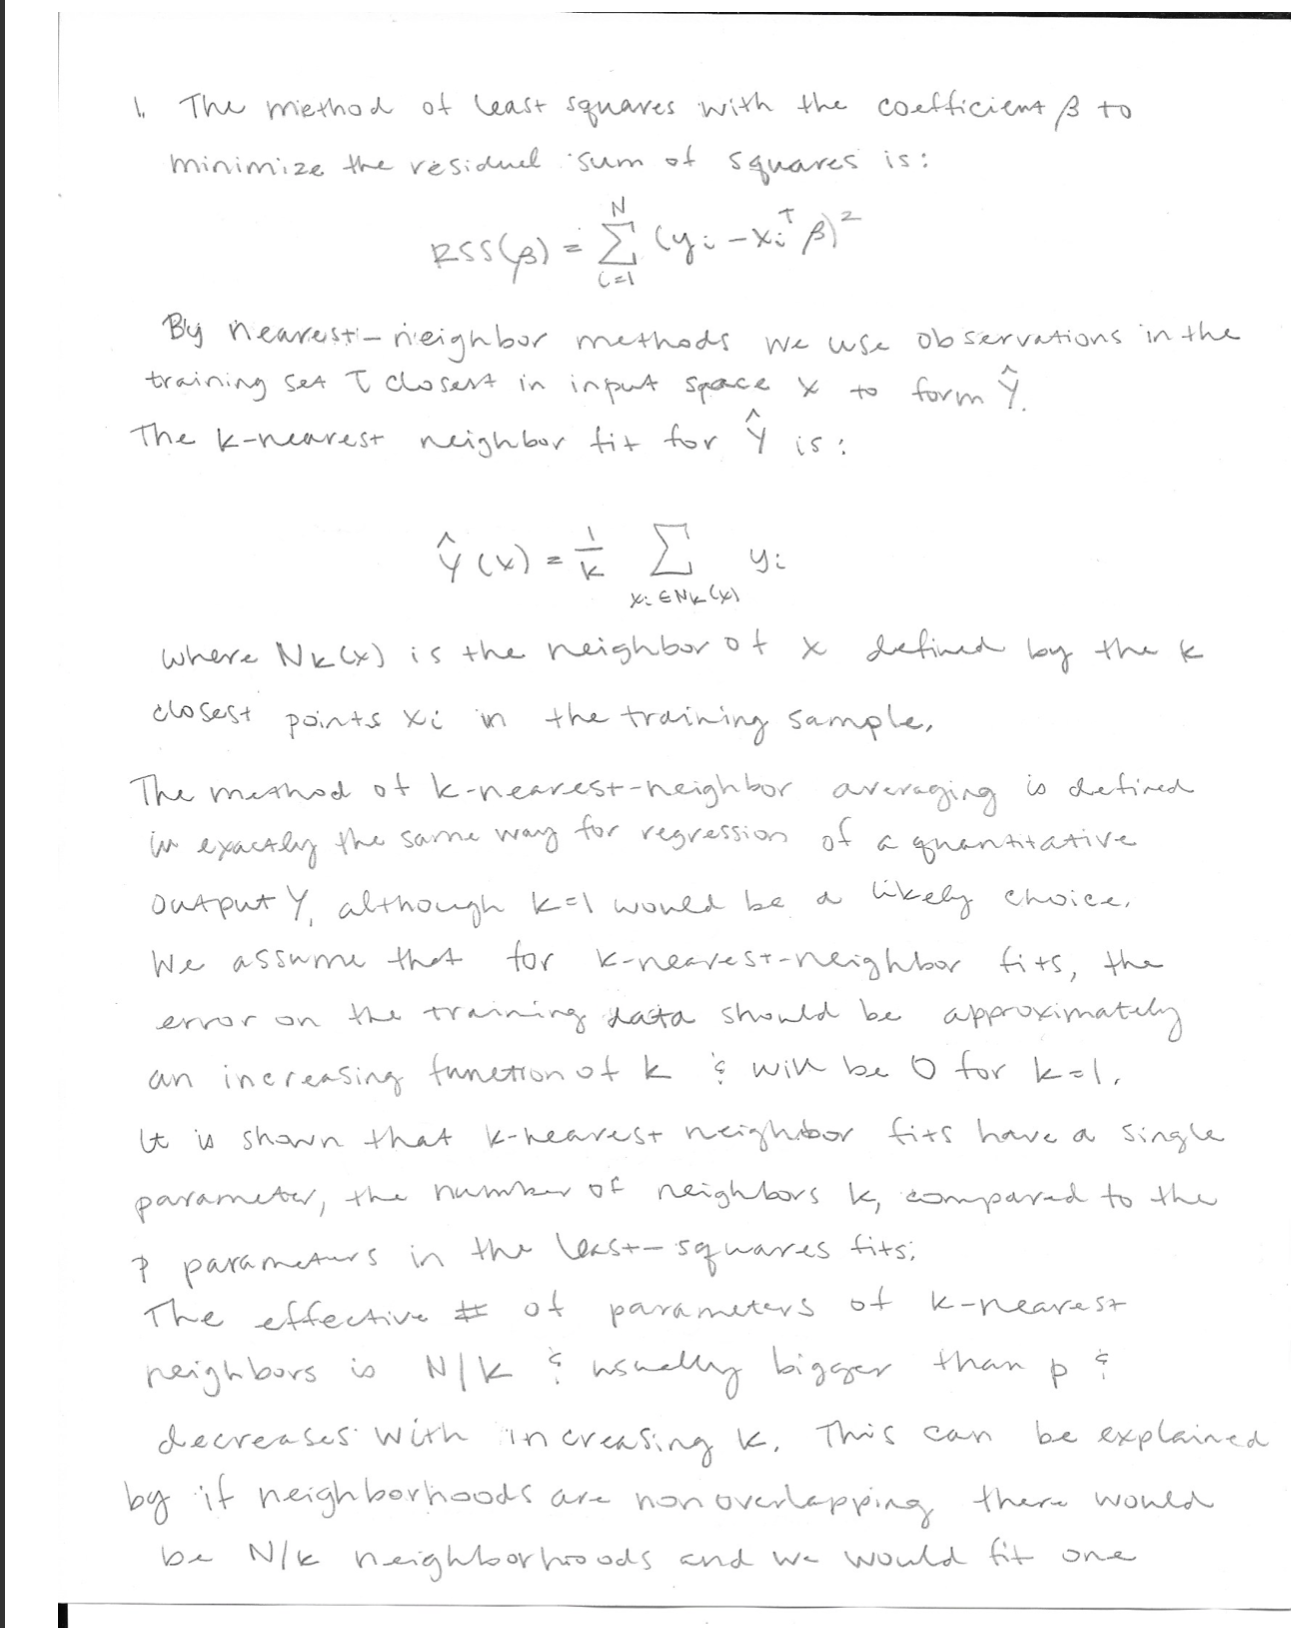

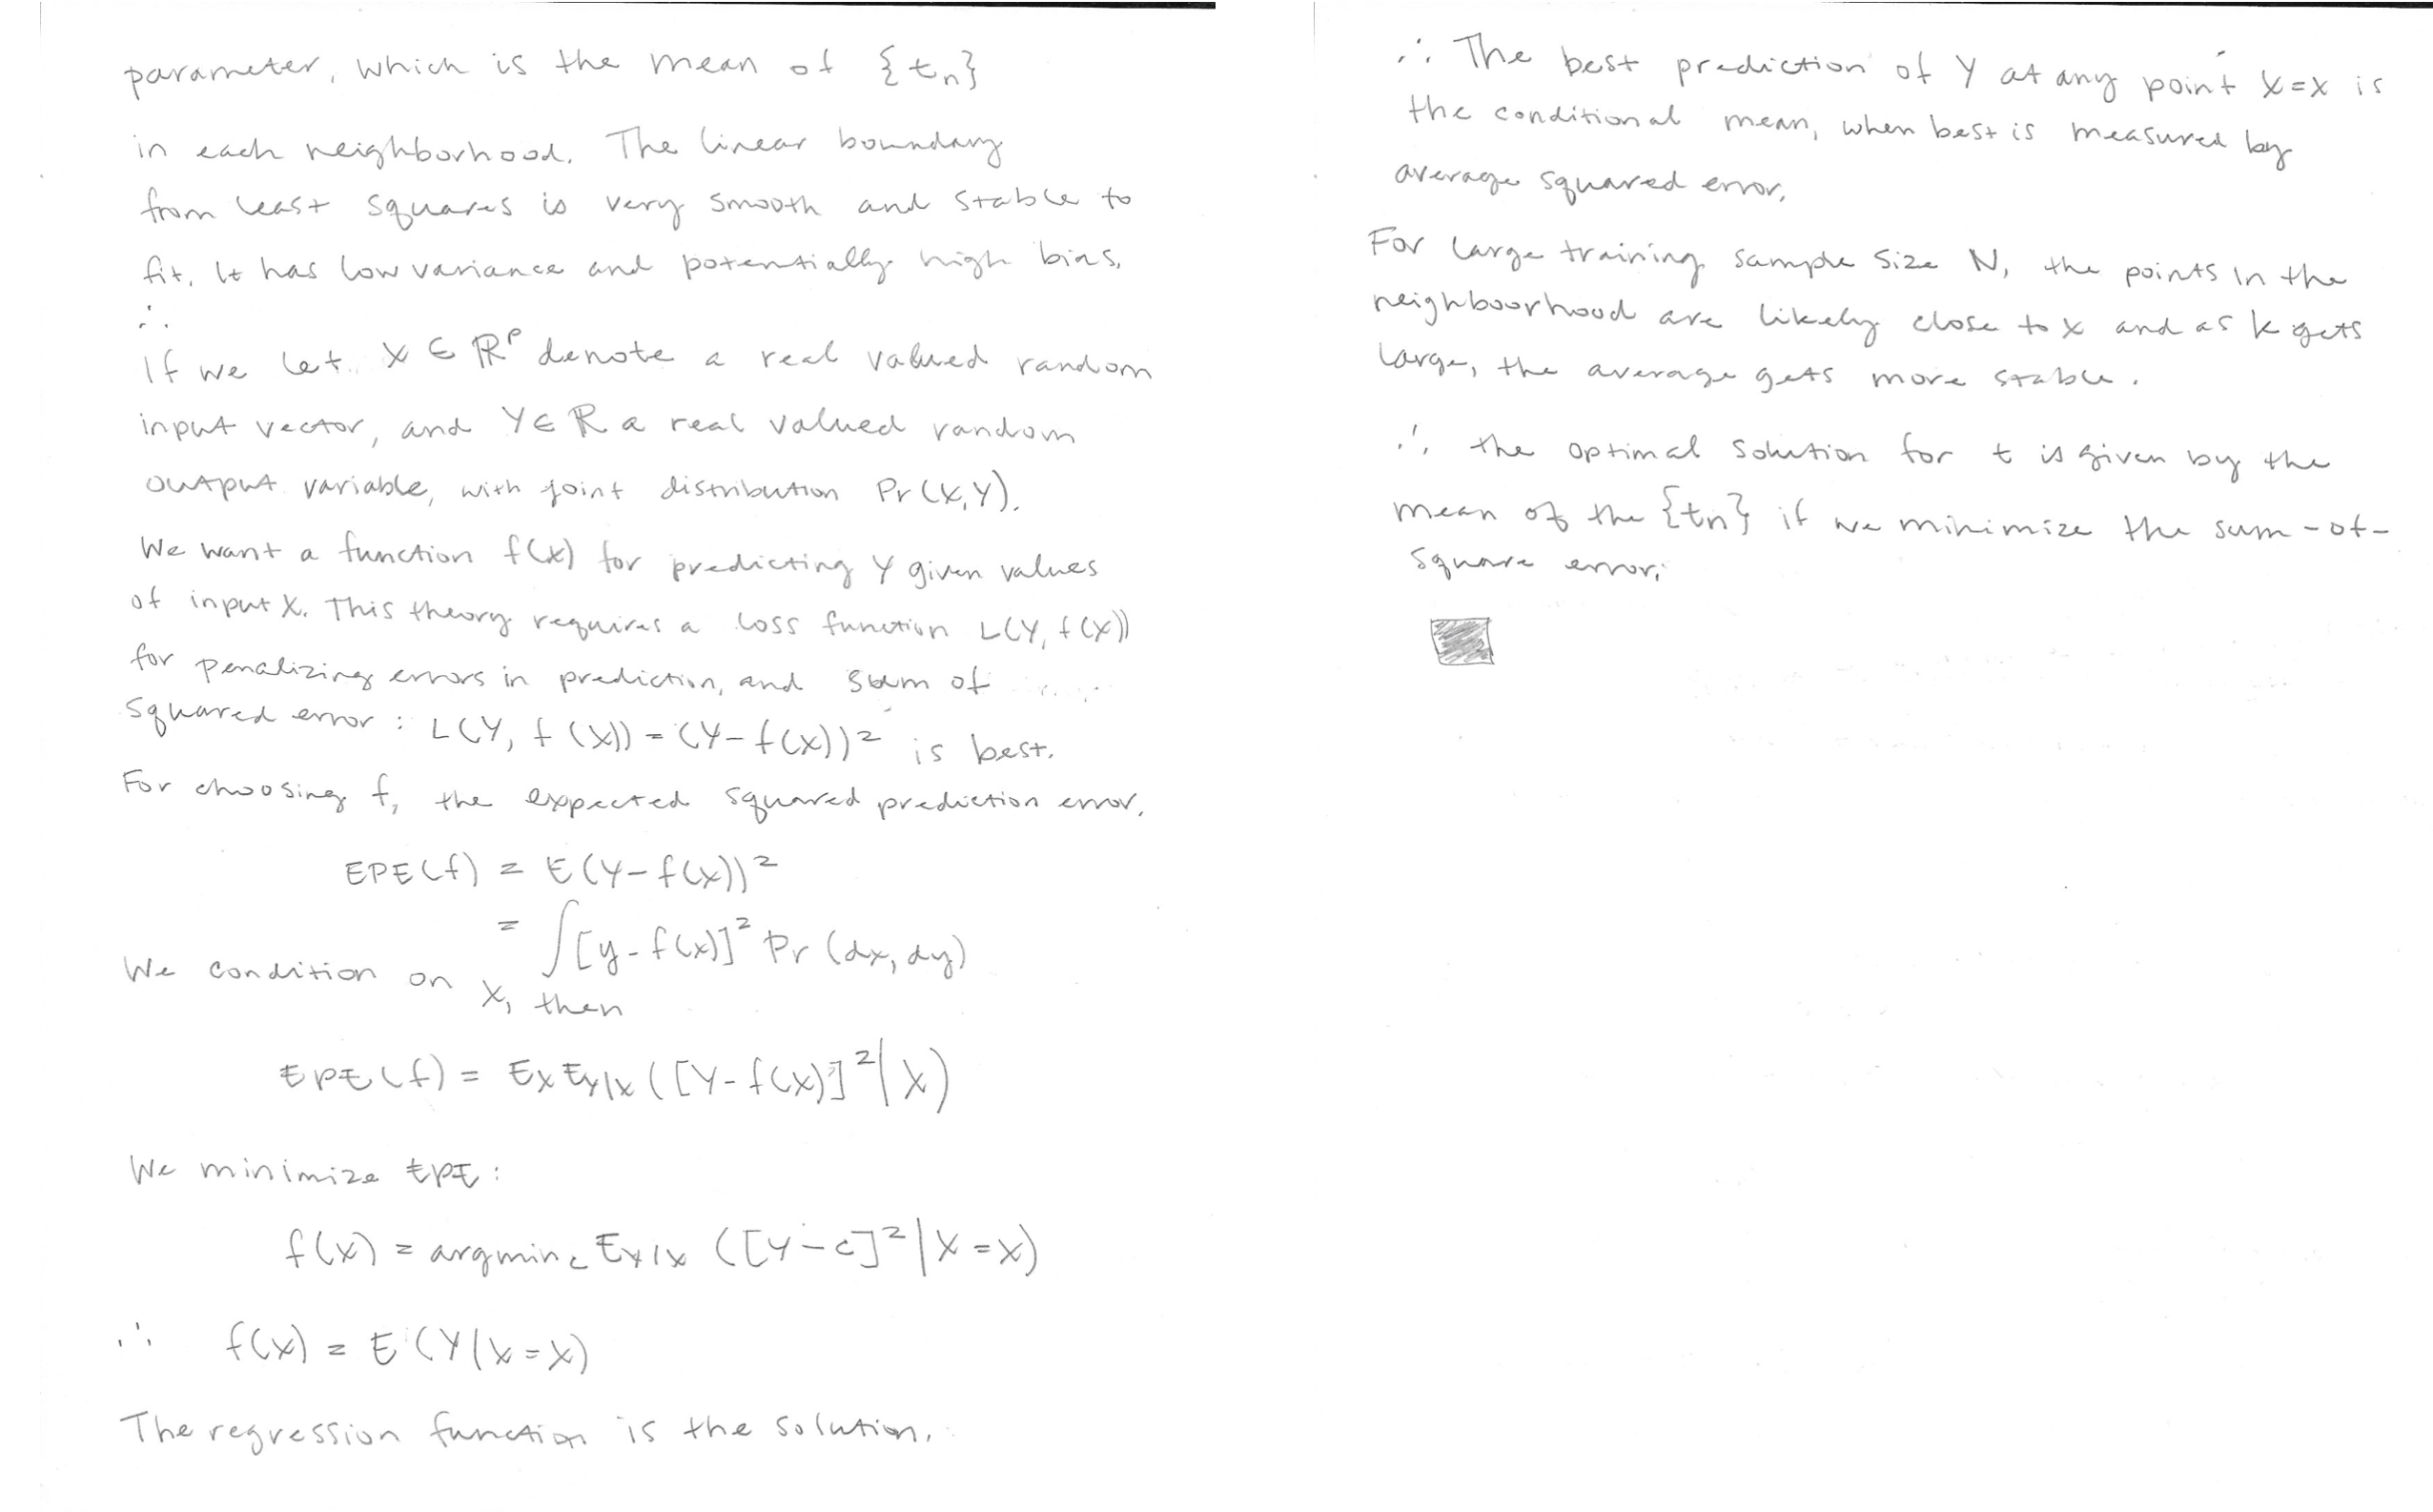

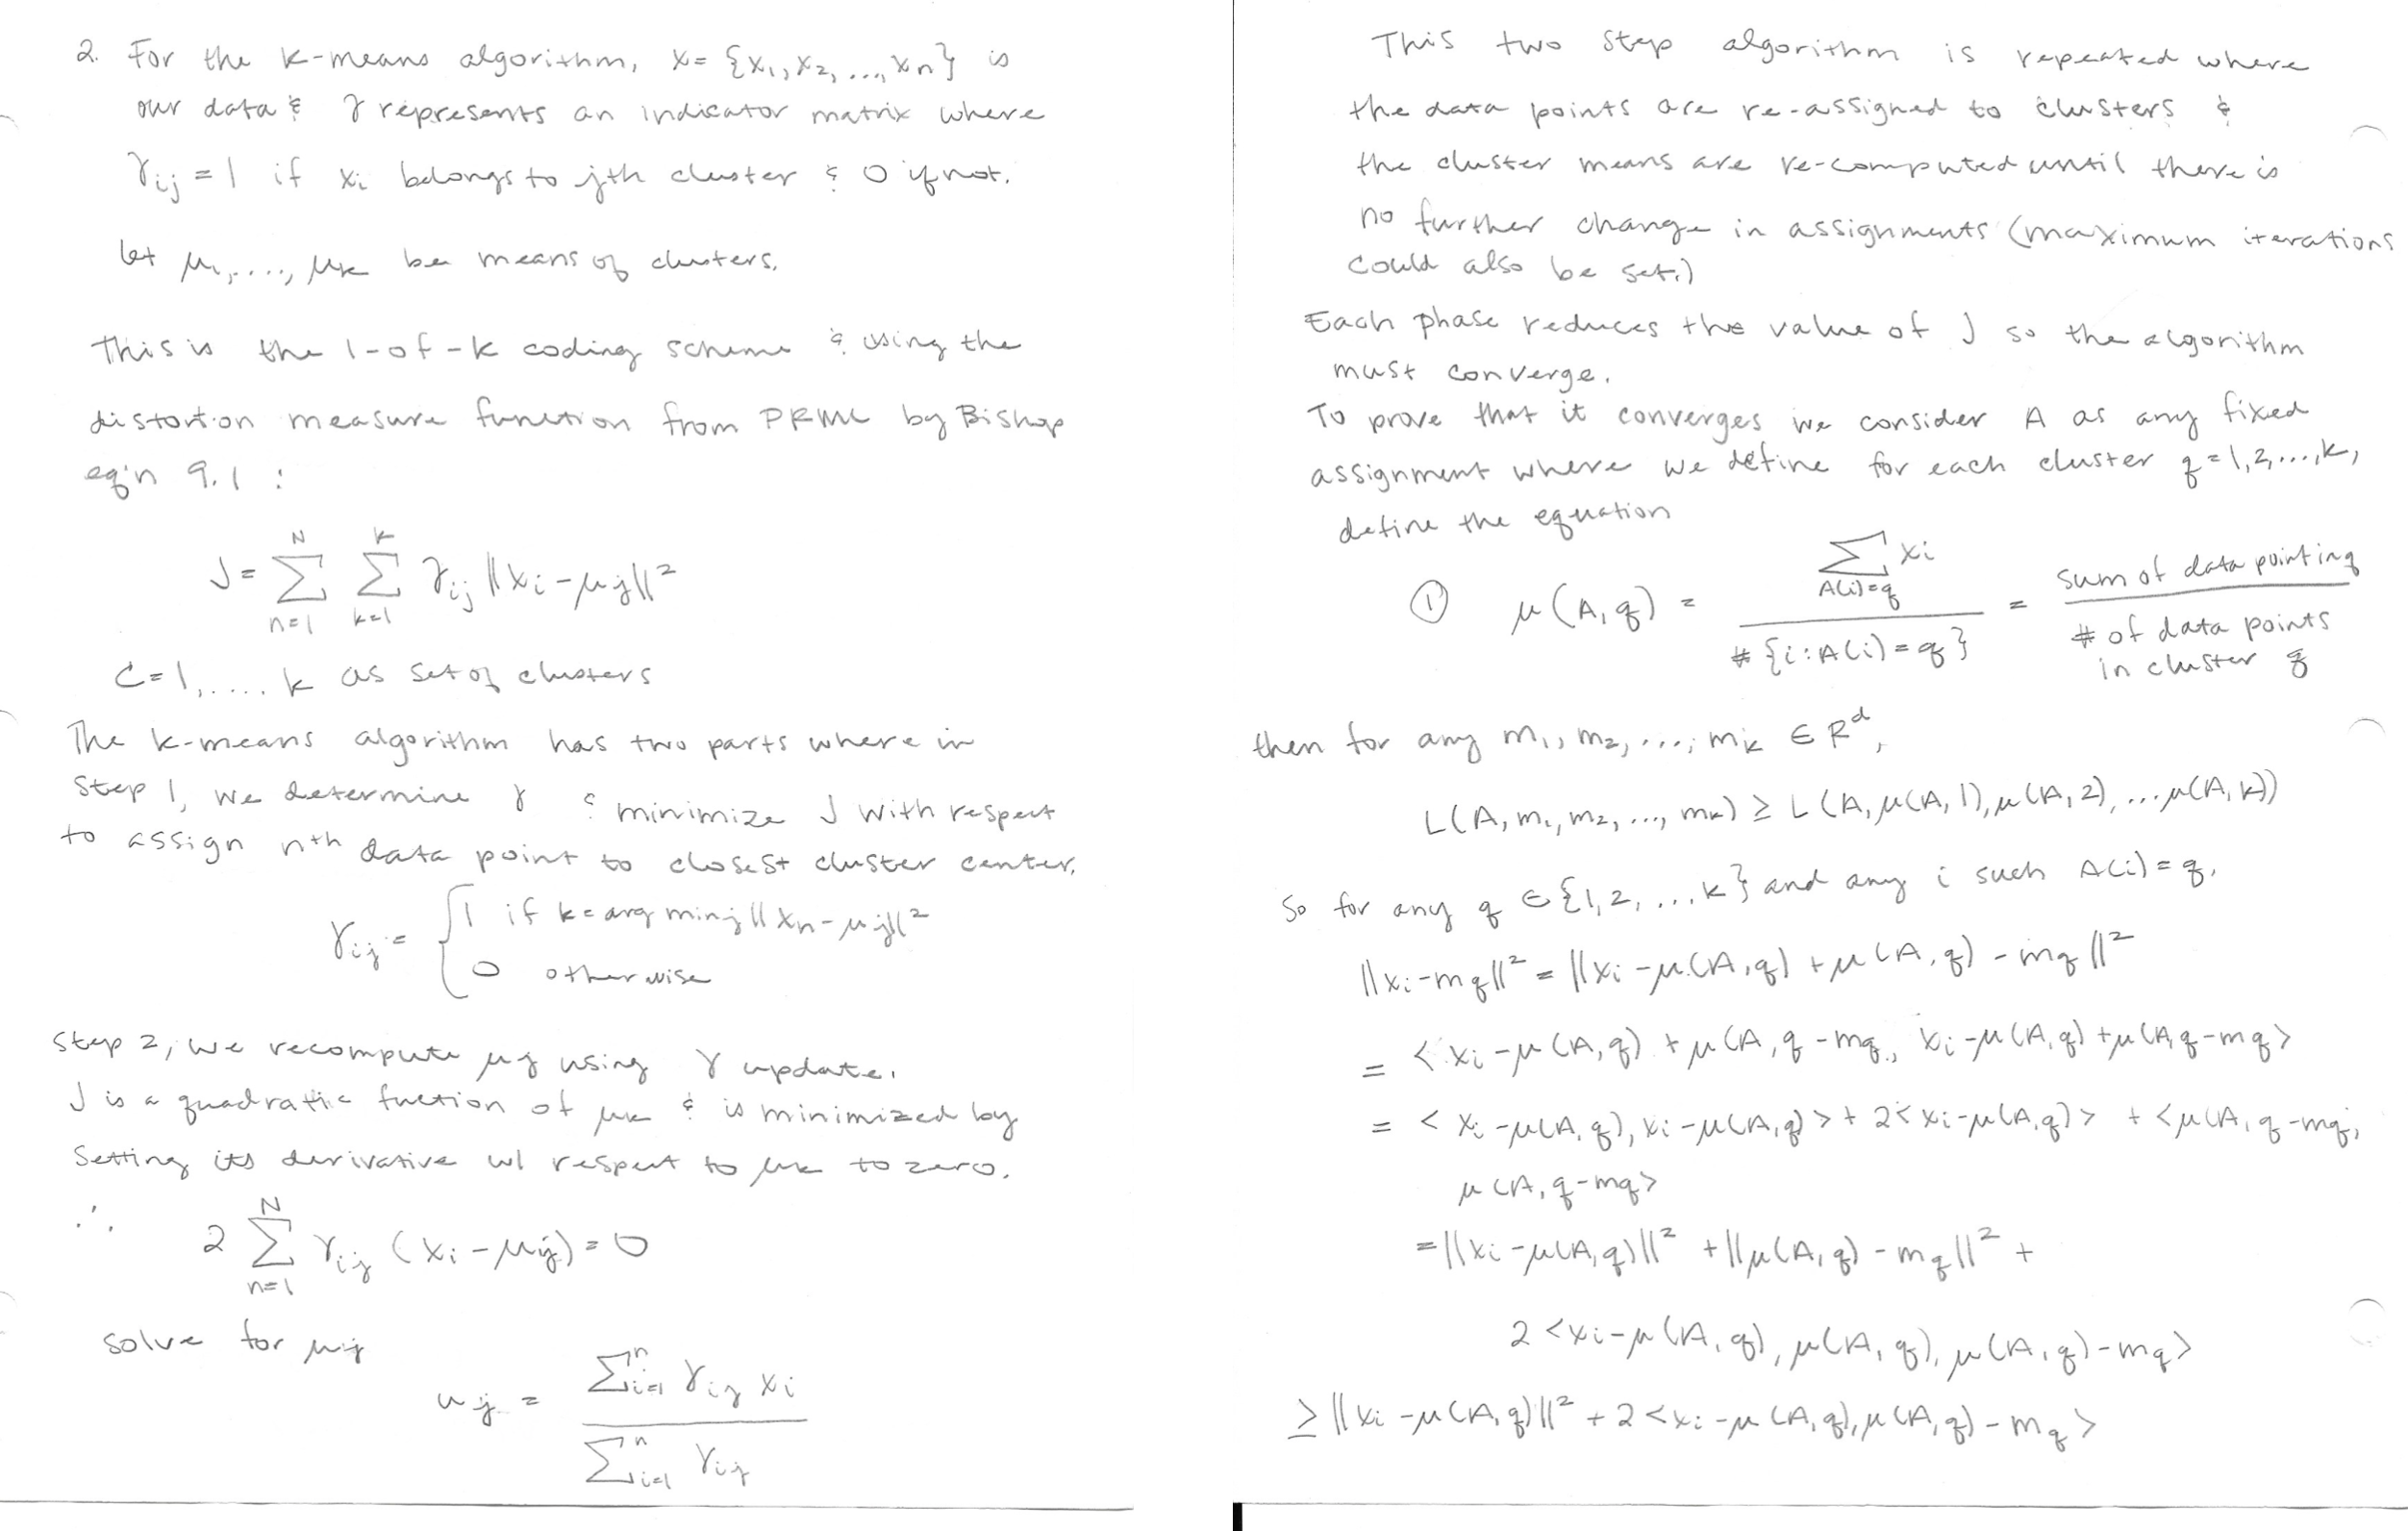

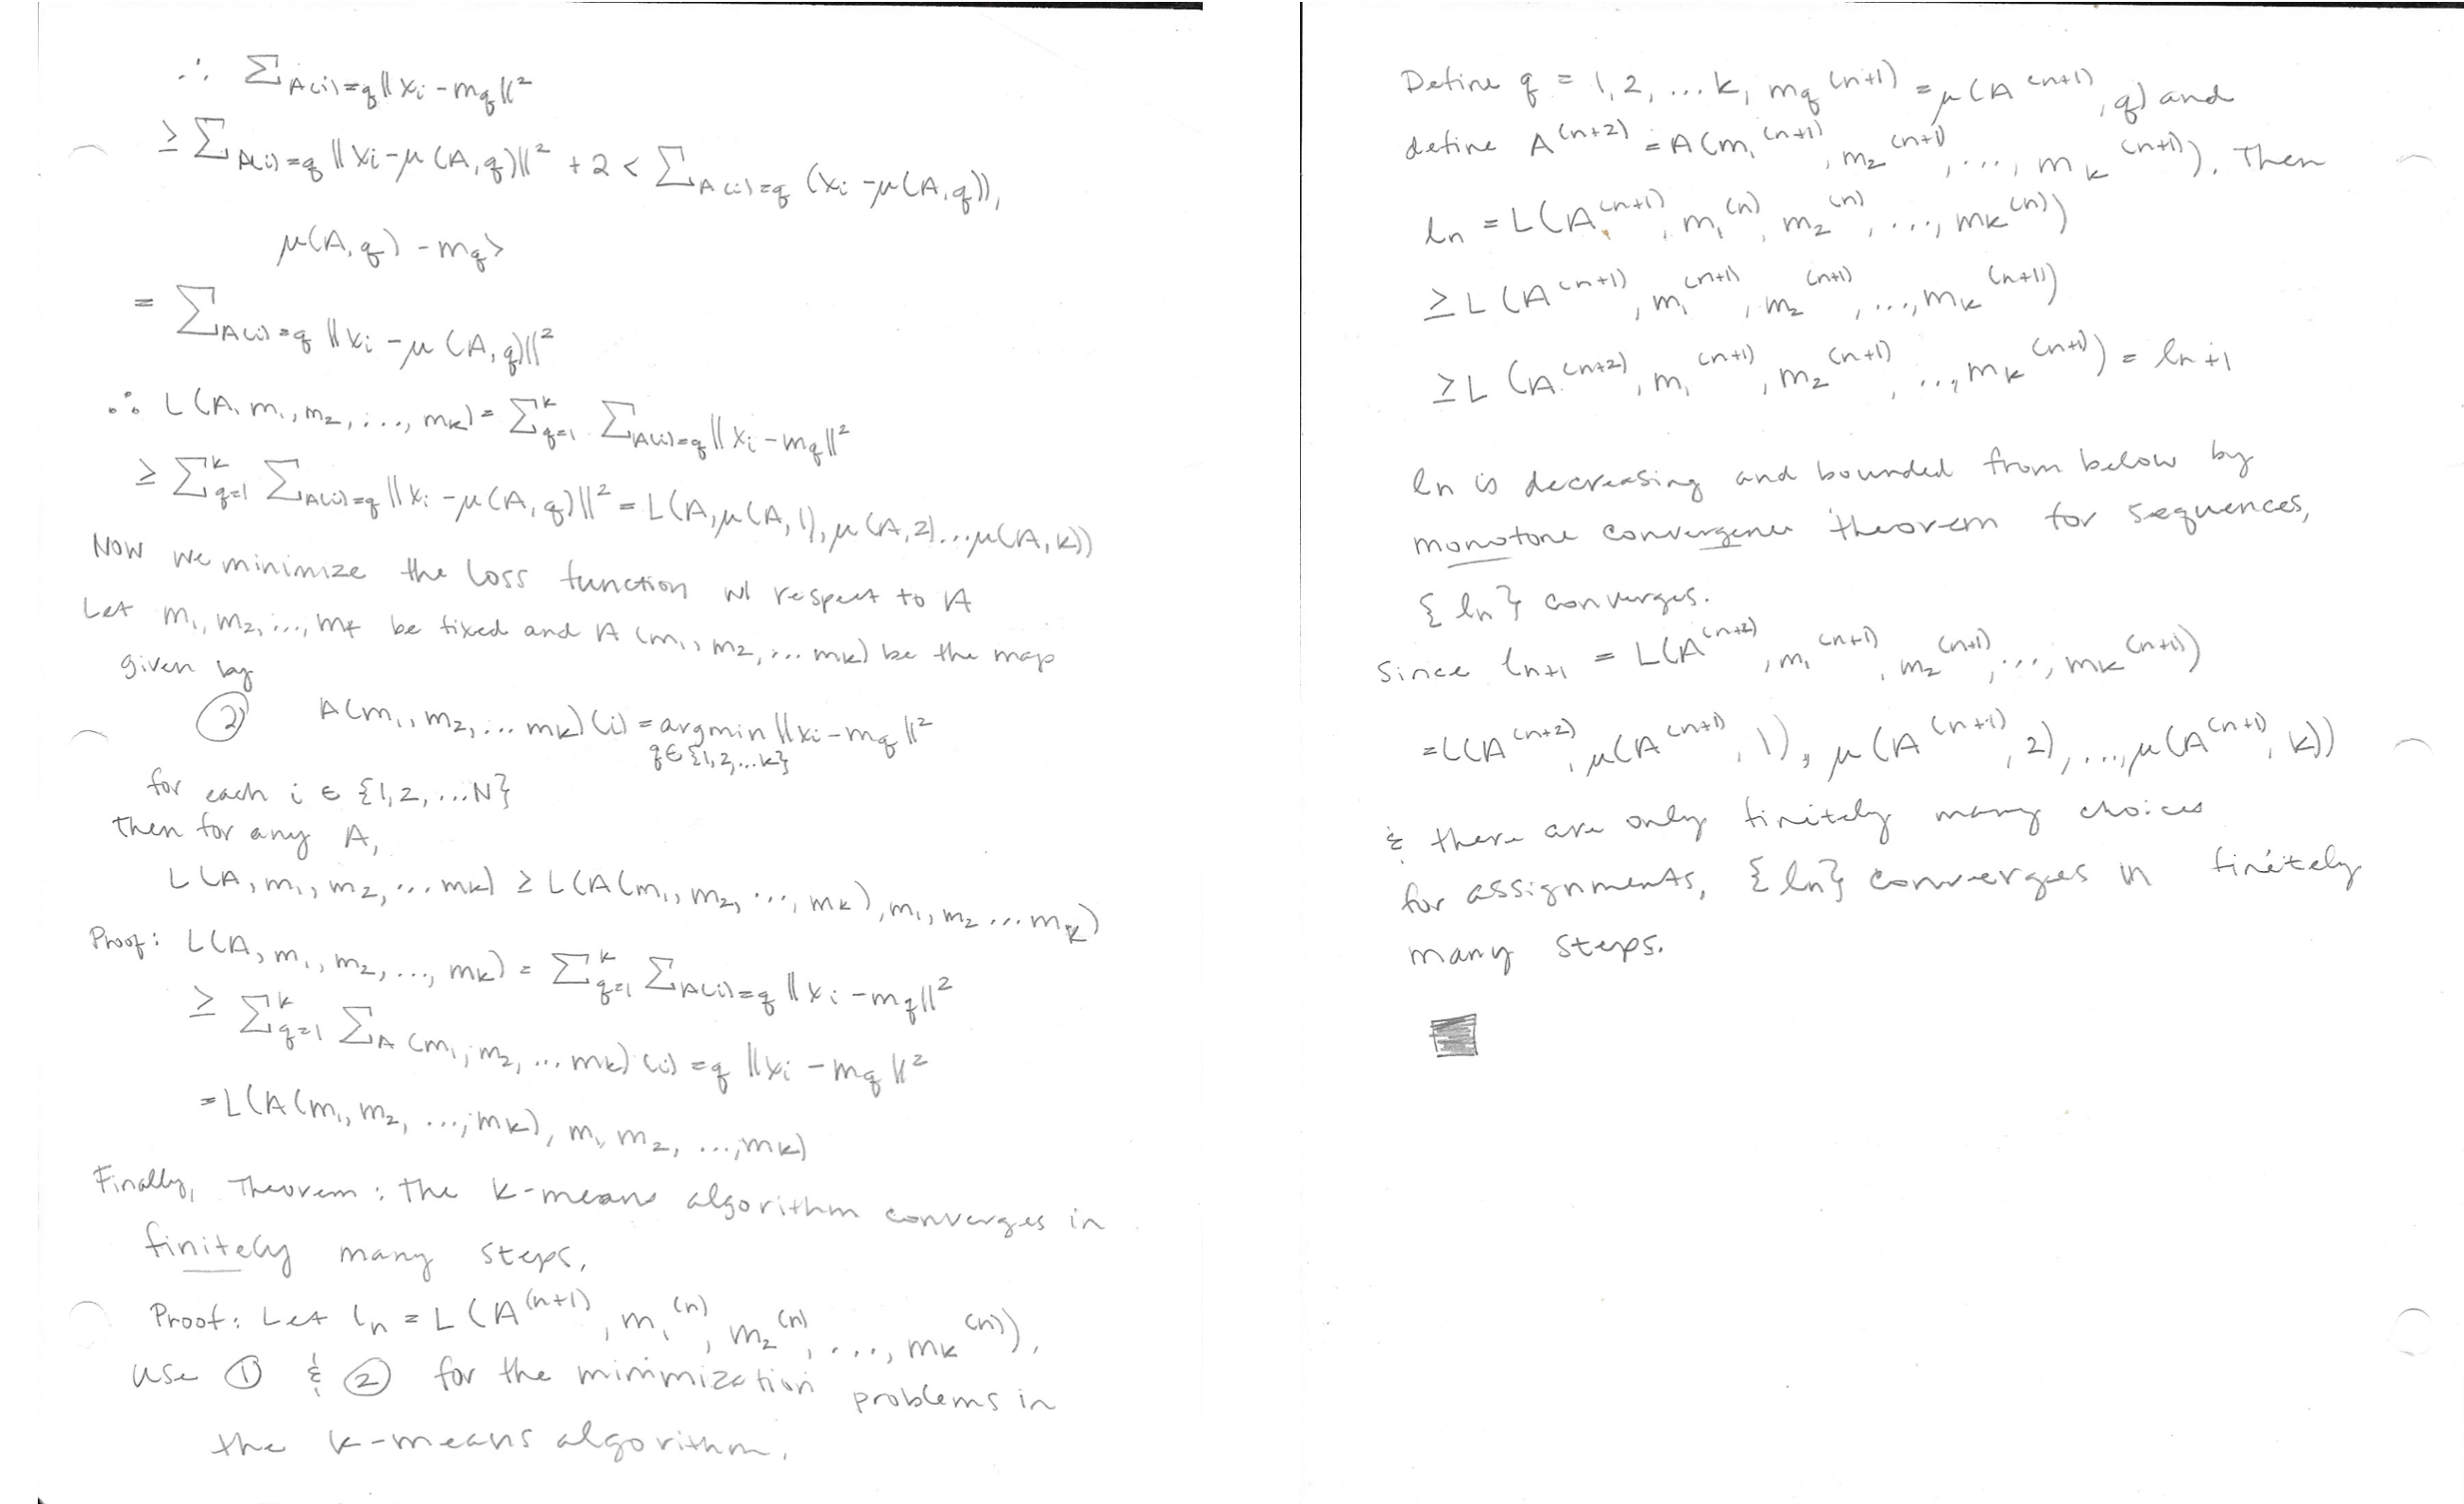

3. Random sampling, k-means++